# 0. 환경 준비

구글 드라이브 파일 연동

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


라이브러리 준비

In [193]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import missingno as msno
from scipy import stats

#import folium
#from folium import plugins
#from shapely.geometry import shape, Point, multipolygon

#from sklearn.preprocessing import LabelEncoder

#import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 준비

In [197]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/E-06 DATA/train.csv')

print(train.shape)
train.head()

(15035, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [198]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/E-06 DATA/test.csv')

print(test.shape)
test.head()

(6468, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [199]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [200]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

# 2. EDA (Exploratory Data Analysis)

Feature 확인

1) 가격 분포 확인

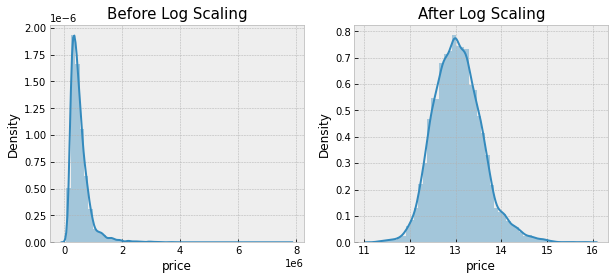

In [201]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

sns.distplot(train['price'], ax=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
sns.distplot(np.log1p(train['price']), ax=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

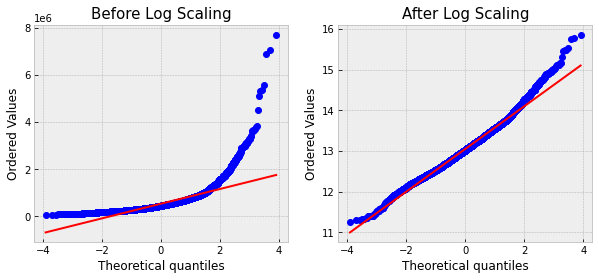

In [202]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

reg = stats.probplot(train['price'], plot=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
reg = stats.probplot(np.log1p(train['price']), plot=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

2) 주요 Feature 시각화

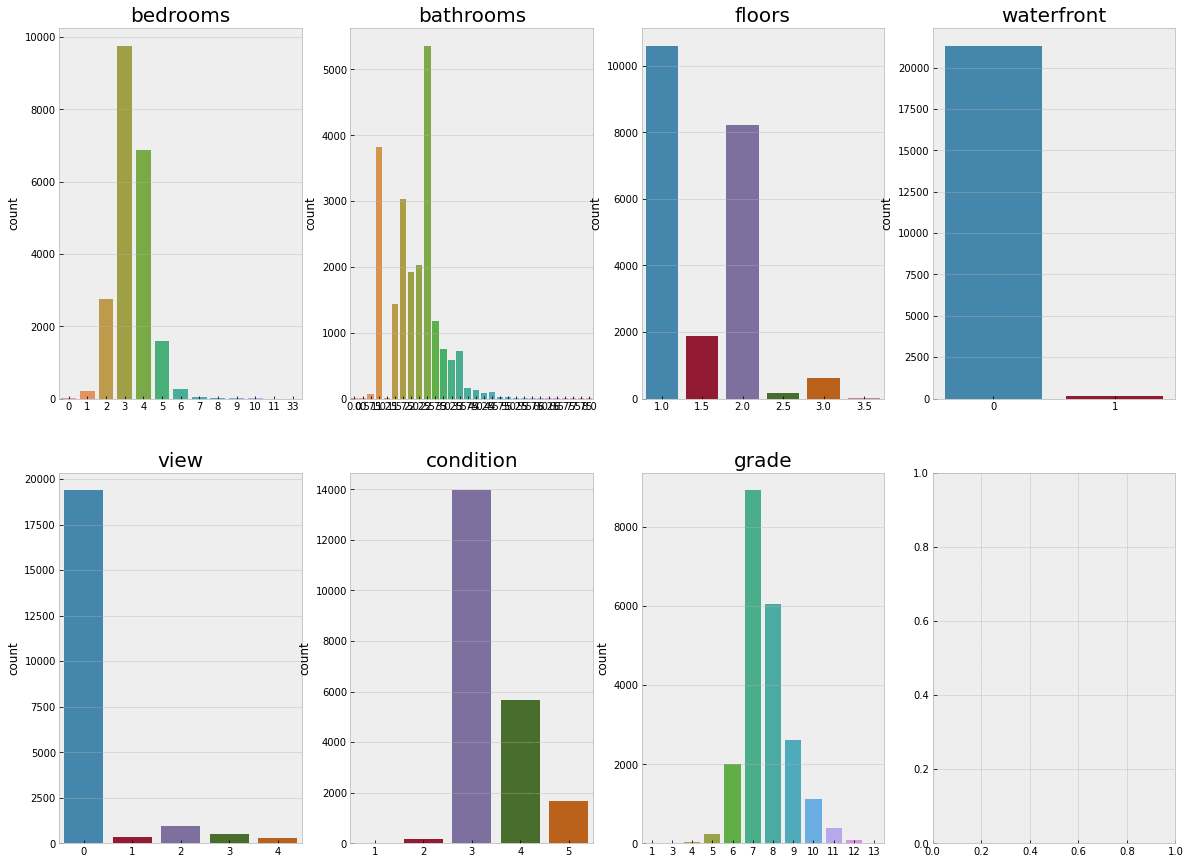

In [203]:
count_info = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
fig, axes = plt.subplots(2, 4, figsize=(20,15))

for r in range(2):
  for c in range(4):
    index = 4 * r + c
    if index == len(count_info):
      break
    sns.countplot(data=data, x=count_info[index], ax=axes[r, c])
    axes[r, c].set_xlabel('')
    axes[r, c].set_title(count_info[index], fontsize=20)

#3. Preprocessing

1) 날짜 데이터 정리

In [204]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
del train['id']

In [205]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


2) 가격 데이터 정리

In [206]:
y = train['price']
del train['price']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


3) 결측치 확인

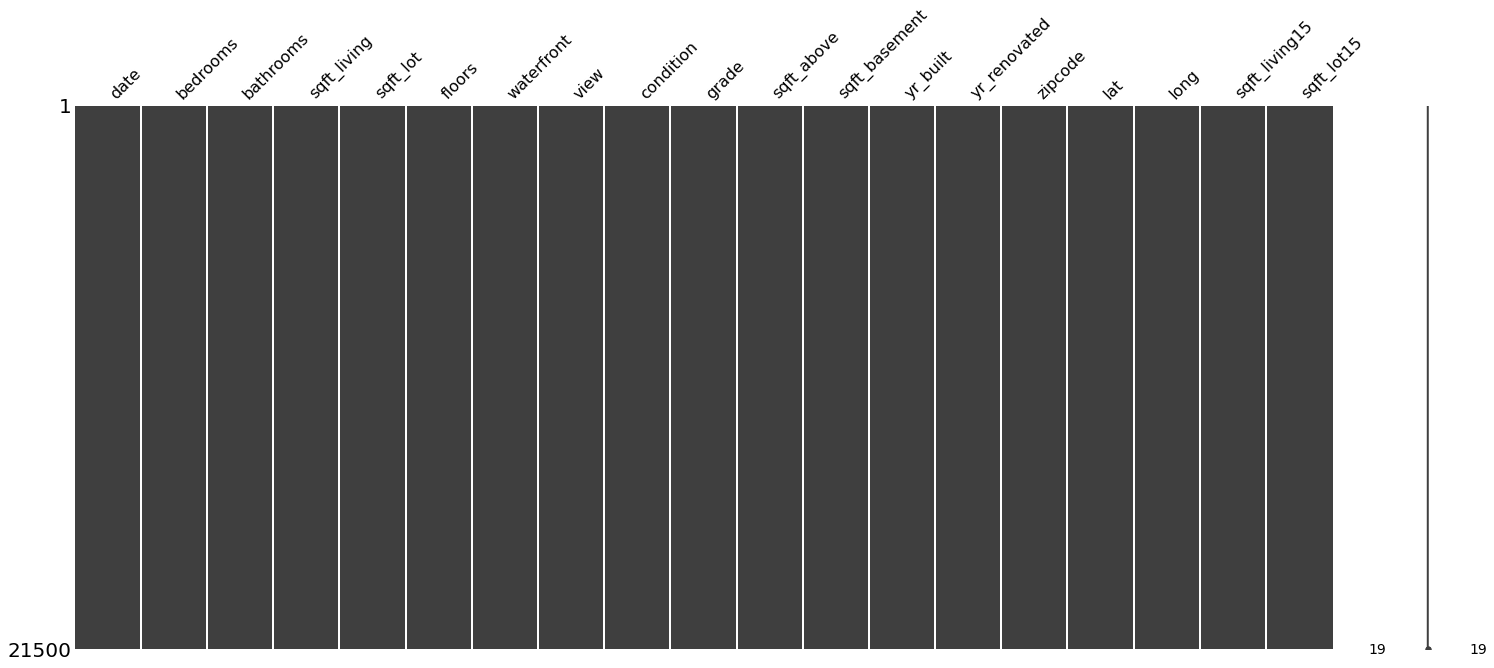

In [207]:
msno.matrix(data)

In [208]:
for c in data.columns:
  print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


4) 데이터 합치기

In [209]:
data = pd.merge(train, test, how='outer')

print(data.shape)
data.head()

(21500, 19)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


5) 가격 분포 조정

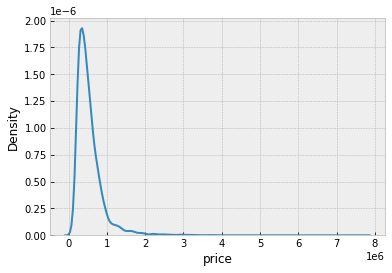

In [210]:
sns.kdeplot(y)
plt.show()

In [211]:
y = np.log1p(y)

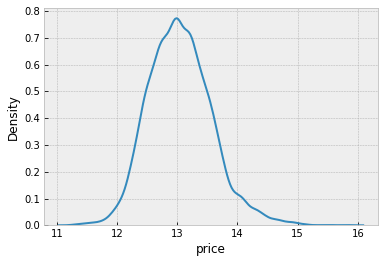

In [212]:
sns.kdeplot(y)
plt.show()

In [213]:
data.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [214]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 4. Modeling

1) 예측 모델

In [128]:
#평가할 rmse 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [132]:
random_state=2020 

lightgbm = LGBMRegressor(random_state=random_state)
models = [lightgbm]

In [133]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'LGBMRegressor': 111920.36735892233}

In [134]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
LGBMRegressor,111920.367359


그리드 탐색

In [135]:
from sklearn.model_selection import GridSearchCV

In [136]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [161]:
model = LGBMRegressor(random_state=random_state)

In [138]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    6.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=2020,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_s

In [139]:
grid_model.cv_results_

{'mean_fit_time': array([0.28961134, 0.37112308, 0.97216139, 1.5333683 ]),
 'mean_score_time': array([0.02060533, 0.0327199 , 0.05330524, 0.05410047]),
 'mean_test_score': array([-0.07339447, -0.05502043, -0.02917734, -0.02702714]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904, -0.05546079, 

In [142]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [143]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [144]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [146]:
results['RMSLE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [147]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [148]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [149]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    3.5s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


- Hyper Parameter 1 : max_depth=10
- Hyper Parameter 2 : max_depth=20, learning_rate=0.05, num_iterations=1000
- Hyper Parameter 3 : max_depth=30, learning_rate=0.1, num_iterations=3000 --> Private Score: 111455
- Hyper Parameter 4 : max_depth=50, learning_rate=0.1, num_iterations=7000
- Hyper Parameter 5 : max_depth=50, learning_rate=0.1, num_iterations=3000 --> Private Score: 111455
- Hyper Parameter 6 : max_depth=30, learning_rate=0.1, num_iterations=10000
- 반복학습량을 3000이상으로 늘릴수록 Private Score 값이 올라간다.
- max_depth=10, num_leaves=1023으로 했을 때, 처음 값과 차이가 미미하다.

In [282]:
model = LGBMRegressor(max_depth=30, n_estimators=100, learning_rate=0.1, num_iterations=3000, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.1302802 , 13.10669989, 14.00755118, ..., 13.05949715,
       12.67649589, 13.00836273])

In [283]:
prediction = np.expm1(prediction)
prediction

array([ 503973.12166271,  492228.27129205, 1211718.73773936, ...,
        469533.54439611,  320133.30577618,  446127.68860017])

In [257]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/E-06 DATA/sample_submission.csv'

#submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(data_dir)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [284]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.039731e+05
1,15036,4.922283e+05
2,15037,1.211719e+06
3,15038,3.083110e+05
4,15039,3.099444e+05


제출 파일 생성

In [281]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/E-06 DATA'

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/Colab Notebooks/E-06 DATA/submission_lgbm_RMSLE_0.164399.csv


Kaggle Submission

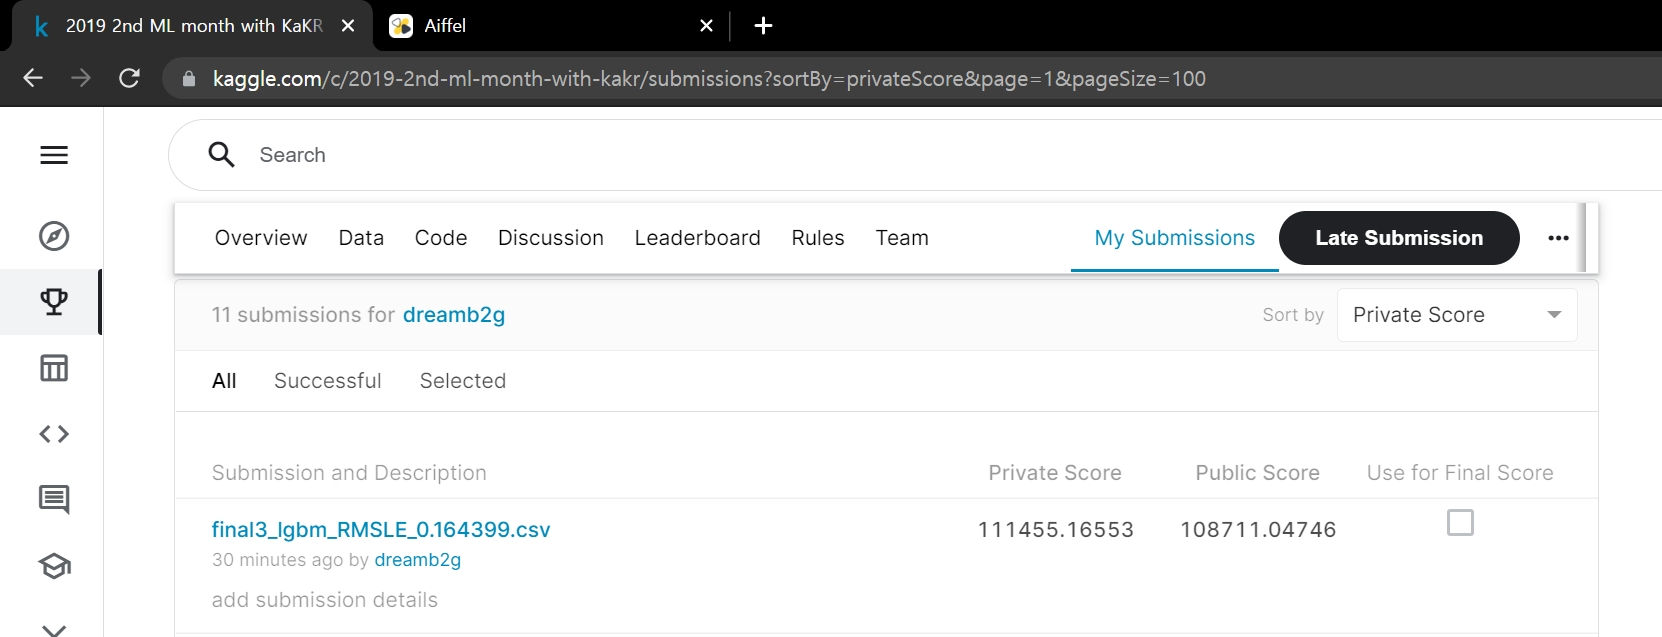

#회고

- E-06 노드는 캐글에서 커널을 필사하며 배운다는 전략을 선택했다.
- Most Votes 또는 Best Score 중에서 참고할 커널을 선정했다.
- lgbm Model의 HyperParameter를 조정해서 실험해 보았다.
- 해커톤에서 원하는 스코어 값과 너무 큰 차이가 나는 점수가 나와서 lgbm에서 앙상블로 변경하여 스코어 값을 대폭 낮출 수 있었는데, 그런 경험으로 보아 확실히 lgbm 모델의 하이퍼파라미터를 조정해도 결과 값에 큰 차이가 없음을 재확인할 수 있었다.
- 110000 이하의 Private Score를 만들기 위해서는 모델을 앙상블해야 할 것이라는 추측성 결론으로 마무리한다.